In [194]:
using Pkg
Pkg.activate("..")

  Activating project at `~/PhD/MatrixProductBP.jl`


In [195]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, TensorTrains, SparseArrays
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using SparseArrays
using Plots

In [196]:
seed = 20
rng = MersenneTwister(seed)

T = 10
N = 5
gg = uniform_tree(N; rng)
g = IndexedGraph(gg)

β = 0.7
J = 1.0
h = 0.2
m⁰ = 1.0
K = 200

;

In [197]:
connected_components(gg)

1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5]

In [198]:
g.A

5×5 SparseMatrixCSC{Int64, Int64} with 8 stored entries:
 ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  2  ⋅
 ⋅  ⋅  ⋅  3  ⋅
 1  2  3  ⋅  4
 ⋅  ⋅  ⋅  4  ⋅

In [199]:
ϕᵢ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]
ϕ = fill(ϕᵢ, nv(g))

ising = Ising(g, fill(J,ne(g)), fill(h, nv(g)), β)
bp = Glauber(ising, T; ϕ) |> mpbp

g_ = IndexedBiDiGraph(gg)
w_fourier = [fill(GlauberFactor(fill(J,length(inedges(g,i))), h, β), T+1) for i in vertices(g)]
bp_fourier = mpbp(ComplexF64, g_, w_fourier, fill(2, nv(g)), T; ϕ)
;

In [208]:
matrix_sizes = [5, 10, 15]
maxiters = [5, 0, 0]
iters = zeros(Int, length(maxiters))
tol = 1e-16

for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), tol)
end

In [209]:
iters_fourier = zeros(Int, length(maxiters))
for i in eachindex(maxiters)
    iters_fourier[i], cb_fourier = iterate_fourier!(bp_fourier, K, maxiter=maxiters[i], σ=1/200; svd_trunc=TruncBond(matrix_sizes[i]), tol)
end

In [202]:
nsamples = 10^5
sms = SoftMarginSampler(bp)
sample!(sms, nsamples);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:00


In [210]:
# potts2spin(x; q=2) = (x-1)/(q-1)*2 - 1

i = 1
m = means(potts2spin, bp)[i]
m_fourier = real.(means(potts2spin, bp_fourier))[i]
traj = [vec(potts2spin.(X[i,:])) for X in sms.X]
m_mc = mean(traj)
;

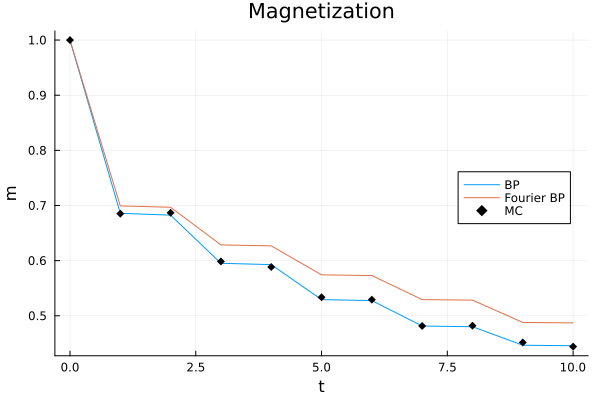

In [211]:
pl = plot(0:T, m[1:end], label="BP", xlabel="t", ylabel="m", title="Magnetization", legend=:right)
plot!(pl, 0:T, m_fourier[1:end], label="Fourier BP")
plot!(pl, 0:T, m_mc, c=:black, m=:diamond, st=:scatter, label="MC")
display(pl)